In [115]:
import pandas as pd
import numpy as np
import sklearn
from matplotlib import pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [127]:
data_1 = False

if data_1:
    data = pd.read_csv("data.csv")
    data = data.dropna()
    data["diagnosis"] = data["diagnosis"].map({"M": 1, "B": 0})
else:
    data = pd.read_csv("data2.csv")
    data = data.dropna()
    data["tumor-size"] = (
        data["tumor-size"].replace("14-Oct", "10-14").replace("9-May", "9")
    )
    data["inv-nodes"] = (
        data["inv-nodes"]
        .replace("11-Sep", "9-11")
        .replace("5-Mar", "3-5")
        .replace("14-Dec", "12-14")
    )

    mappings = {}
    offset = 0
    for col in data.columns:
        if data[col].dtype == "object":
            mapping = {v: k for k, v in enumerate(data[col].unique())}
            mapping = {k: v + offset for k, v in mapping.items()}
            offset += len(mapping)
            data[col] = data[col].map(mapping)
            mapping = {v: f"{col}={k}" for k, v in mapping.items()}
            mappings.update(mapping)

print(data.shape)
data.head()

(277, 11)


,id,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,0,0,2,8,11,22,29,3,31,33,38
1,1,0,3,8,12,22,29,2,32,34,38
2,2,0,3,8,12,22,29,2,31,33,38
3,3,0,4,9,13,22,29,2,32,35,38
4,4,0,3,8,14,22,29,2,32,36,38


In [117]:
# split data into features and target:
if data_1:
    X = data.drop(["diagnosis"], axis=1)
    y = data["diagnosis"]
else:
    X = data.drop(["Class"], axis=1)
    y = data["Class"]

# split data into training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=(42 if data_1 else 0)
)

In [118]:
# random forest classifier:
rf_clf = RandomForestClassifier()
scores = cross_val_score(rf_clf, X_train, y_train, cv=5)
print("Cross validation scores: ", scores)
print("Mean score: ", scores.mean())

rf_clf.fit(X_train, y_train)
test_score = rf_clf.score(X_test, y_test)
print("Test set score: ", test_score)


Cross validation scores:  [1.         1.         1.         1.         0.97727273]
Mean score:  0.9954545454545455
Test set score:  0.9821428571428571


In [119]:
# use grid search to find the best hyperparameters:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 5, 7],
    "max_features": [5, 10, 15],
}

grid_search = GridSearchCV(rf_clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)
print("Test set score: ", grid_search.score(X_test, y_test))

Best parameters:  {'max_depth': 3, 'max_features': 5, 'n_estimators': 50}
Best cross-validation score:  1.0
Test set score:  0.9821428571428571


In [120]:
# find if different measure matters. try precision, recall, f1 score:
def grid_search_with_scoring(scoring):
    grid_search = GridSearchCV(rf_clf, param_grid, cv=5, scoring=scoring)
    grid_search.fit(X_train, y_train)
    print("Best parameters: ", grid_search.best_params_)
    print("Best cross-validation score: ", grid_search.best_score_)
    print("Test set score: ", grid_search.score(X_test, y_test))

for scoring in ["precision", "recall", "f1"]:
    print(f"Scoring with {scoring}:")
    grid_search_with_scoring(scoring)

Scoring with precision:
Best parameters:  {'max_depth': 3, 'max_features': 5, 'n_estimators': 50}
Best cross-validation score:  1.0
Test set score:  1.0
Scoring with recall:
Best parameters:  {'max_depth': 3, 'max_features': 5, 'n_estimators': 50}
Best cross-validation score:  1.0
Test set score:  0.9444444444444444
Scoring with f1:
Best parameters:  {'max_depth': 3, 'max_features': 5, 'n_estimators': 50}
Best cross-validation score:  1.0
Test set score:  0.9714285714285714


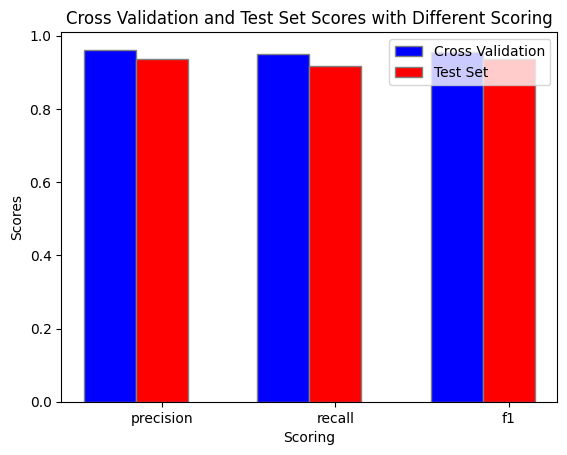

In [121]:
# Scoring with precision:
# Best parameters:  {'max_depth': 7, 'max_features': 10, 'n_estimators': 200}
# Best cross-validation score:  0.9618817204301076
# Test set score:  0.9375
# Scoring with recall:
# Best parameters:  {'max_depth': 3, 'max_features': 15, 'n_estimators': 50}
# Best cross-validation score:  0.948991935483871
# Test set score:  0.9183673469387755
# Scoring with f1:
# Best parameters:  {'max_depth': 7, 'max_features': 15, 'n_estimators': 50}
# Best cross-validation score:  0.9549836114383614
# Test set score:  0.9375

# plot above result:
cross_validation_scores = [0.9618817204301076, 0.948991935483871, 0.9549836114383614]
test_set_scores = [0.9375, 0.9183673469387755, 0.9375]
scorings = ["precision", "recall", "f1"]

# bar plot, two bar side by side:
barWidth = 0.3
r1 = np.arange(len(cross_validation_scores))
r2 = [x + barWidth for x in r1]
plt.bar(r1, cross_validation_scores, color="blue", width=barWidth, edgecolor="grey", label="Cross Validation")
plt.bar(r2, test_set_scores, color="red", width=barWidth, edgecolor="grey", label="Test Set")
plt.legend()
plt.xlabel("Scoring")
# print the scorings on x-axis:
plt.xticks([r + barWidth for r in range(len(cross_validation_scores))], scorings)
plt.ylabel("Scores")
plt.title("Cross Validation and Test Set Scores with Different Scoring")
plt.savefig("./imgs/cross_validation_and_test_set_scores_with_different_scoring.png")
plt.show()

In [122]:
from sklearn.neighbors import KNeighborsClassifier

# k-nearest neighbors classifier:
knn_clf = KNeighborsClassifier()
scores = cross_val_score(knn_clf, X_train, y_train, cv=5)
print("Cross validation scores: ", scores)
print("Mean score: ", scores.mean())

knn_clf.fit(X_train, y_train)
test_score = knn_clf.score(X_test, y_test)
print("Test set score: ", test_score)

Cross validation scores:  [1.         1.         1.         1.         0.97727273]
Mean score:  0.9954545454545455
Test set score:  0.9821428571428571


In [123]:
param_grid = {
    "n_neighbors": [3, 5, 7, 9],
    "weights": ["uniform", "distance"],
    "p": [1, 2],
}

grid_search = GridSearchCV(knn_clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)
print("Test set score: ", grid_search.score(X_test, y_test))

Best parameters:  {'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
Best cross-validation score:  1.0
Test set score:  0.9821428571428571


In [124]:
from sklearn.feature_selection import SelectKBest, f_classif

# select best features:
selector = SelectKBest(f_classif, k=10)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

grid_search.fit(X_train_selected, y_train)

print("Best parameters: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)
print("Test set score: ", grid_search.score(X_test_selected, y_test))

Best parameters:  {'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
Best cross-validation score:  1.0
Test set score:  0.9821428571428571


In [125]:
def grid_search_with_scoring(scoring):
    grid_search = GridSearchCV(knn_clf, param_grid, cv=5, scoring=scoring)
    grid_search.fit(X_train_selected, y_train)
    print("Best parameters: ", grid_search.best_params_)
    print("Best cross-validation score: ", grid_search.best_score_)
    print("Test set score: ", grid_search.score(X_test_selected, y_test))

for scoring in ["precision", "recall", "f1"]:
    print(f"Scoring with {scoring}:")
    grid_search_with_scoring(scoring)

Scoring with precision:
Best parameters:  {'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
Best cross-validation score:  1.0
Test set score:  1.0
Scoring with recall:
Best parameters:  {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Best cross-validation score:  1.0
Test set score:  0.9444444444444444
Scoring with f1:
Best parameters:  {'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
Best cross-validation score:  1.0
Test set score:  0.9714285714285714


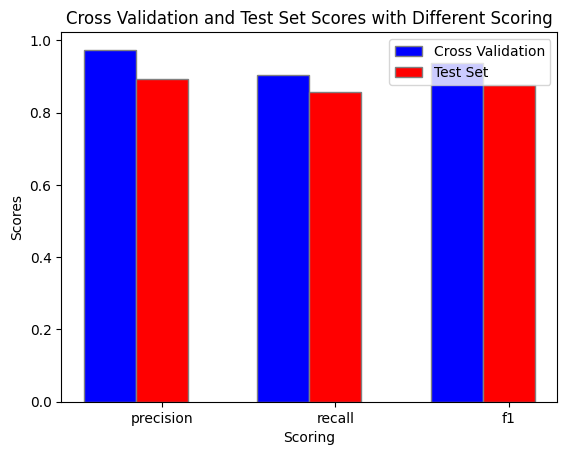

In [126]:
# Scoring with precision:
# Best parameters:  {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
# Best cross-validation score:  0.9737500000000001
# Test set score:  0.8936170212765957
# Scoring with recall:
# Best parameters:  {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
# Best cross-validation score:  0.904233870967742
# Test set score:  0.8571428571428571
# Scoring with f1:
# Best parameters:  {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
# Best cross-validation score:  0.9367660716492752
# Test set score:  0.875

cross_validation_scores = [0.9737500000000001, 0.904233870967742, 0.9367660716492752]
test_set_scores = [0.8936170212765957, 0.8571428571428571, 0.875]
scorings = ["precision", "recall", "f1"]

# bar plot, two bar side by side:
barWidth = 0.3
r1 = np.arange(len(cross_validation_scores))
r2 = [x + barWidth for x in r1]
plt.bar(r1, cross_validation_scores, color="blue", width=barWidth, edgecolor="grey", label="Cross Validation")
plt.bar(r2, test_set_scores, color="red", width=barWidth, edgecolor="grey", label="Test Set")
plt.legend()
plt.xlabel("Scoring")
# print the scorings on x-axis:
plt.xticks([r + barWidth for r in range(len(cross_validation_scores))], scorings)
plt.ylabel("Scores")
plt.title("Cross Validation and Test Set Scores with Different Scoring")
plt.savefig("./imgs/cross_validation_and_test_set_scores_with_different_scoring_knn.png")
plt.show()